<a href="https://colab.research.google.com/github/johanhoffman/DD2363_VT24/blob/Widen00-Lab5/Lab5/Widen00_lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 5: Differential Equations**
**Joel Widén**

# **Abstract**

Differential equations is the cornerstone of connecting math, physics and science. They are used to describe changes of systems in space and time, but also more abstract systems can be modelled using these.

This report is investigating the time dependant differential equations, both scalar and systems of differential equations.

# **About the code**

This is a report in the course DD2363 Methods in Scientific Computing. The author of this file is Joel Widén, joelwid@kth.se.

In [64]:
# Load neccessary modules.
from google.colab import files

import time
import numpy as np

#try:
#    from dolfin import *; from mshr import *
#except ImportError as e:
#    !apt-get install -y -qq software-properties-common
#    !add-apt-repository -y ppa:fenics-packages/fenics
#    !apt-get update -qq
#    !apt install -y --no-install-recommends fenics
#    from dolfin import *; from mshr import *

#import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt
from matplotlib import tri
from matplotlib import axes
from mpl_toolkits.mplot3d import Axes3D

# **Introduction**

Numbered algorithms, equations and chapter references used in this report is from the DD2363 course book Methods in Computational Science by Johan Hoffman if not stated otherwise.

It is claimed by many that differential equations was invented by Isaac Newton when he invented [calculus](https://en.wikipedia.org/wiki/Differential_equation). With these new tools the movement of particles in time could be formulated which sparked a revolution in the understanding of planetary motion.

Today differential equations are used to describe properties of increasingly complex systems. With the introduction of numerical treatment of differential equations this can be implemented into finite element methods and large systems of differential equations can easily be calculated. In this assignment the fundamentals of differential equations will be investigated numerically.

This will be done by solving the following assignments:

**Assignment 1:** Function: Time stepping for scalar initial value problem $du/dt = f(u,t)$

* *Input:* final time $T$, function $f(u,t)$, initial value $u(0)$
* *Output:* approximation $U(t_n)$ for the time interval $[0,T]$
* *Test:* verify accuracy and stability with respect to model problem.

**Assignment 2:** Function: Time stepping for a system of  initial value problems $du/dt = f(u,t)$

* *Input:* final time $T$, function $f(u,t)$, initial value $u(0)$
* *Output:* approximation $U(t_n)$ for the time interval $[0,T]$
* *Test:* verify accuracy and stability with respect to model problem.

# **Method**

**Assignment 1**

This assignment is utilizing the explicit euler method by setting $\theta=1$ in the $\theta$-method. This method is useful as it is quite easy to highlight its behavior regarding accuracy and stability. The parameter $p$ is called $\lambda$ with the meaning as in in the model equation $\dot u = \lambda u$.

This algorithm is based on algorithm 13.3 combined with algorithm 8.2.

In [65]:
#Assignment 1

#Class that saves general parameters in the method that is used by many functions
class Par:
  def __init__(self, u0, t0, k, theta, f, p, T):
    self.u0 = u0
    self.t0 = t0
    self.k = k
    self.theta = theta
    self.f = f
    self.p = p
    self.T = T

def fun1(u, t, p):
  f = p * u
  return f

#Based on algorithm 8.2
def newtons_method(fu, u0, t, par):
  u = u0
  TOL = 10**-3
  while abs(fu(u, t, par)) > TOL:
    df = 1 - par.p * par.k*(1-par.theta)
    u = u - (fu(u, t, par)/df)
  return u

#Making the input to the newton method into inputtable function
def theta_func(u, t, par):
  f = u - par.u0 - par.k*((1-par.theta)*par.f(u, t, par.p) + par.theta*par.f(par.u0, par.t0, par.p))
  return f

#Based on algorithm 13.3
def scalar_time(T, f, u0, k):
  t0 = 0
  t = t0
  dec = int(-1*np.log10(k))
  p = -1
  theta = 1   #0.5=trap, 1=expl, eul, 0=impl, eul
  par = Par(u0, t0, k, theta, f, p, T)
  u_vec = np.zeros(int(T/k)+1)
  u_vec[0] = u0
  i = 1
  while t < T:
    u = newtons_method(theta_func, u0, t, par)
    par.u0 = u
    t = round(t + k, dec+1)
    u_vec[i] = u
    #print(t)
    i += 1
  return u_vec, par

**Assignment 2**

This problem is similar to assignment 1 but expanded to a system of differential equations. The model problem is the same $\dot u = \lambda u$ but here $u$ is a vector and $\lambda$ is a matrix. In this code a system of 2 variables will be investigated. The specific problem is taken from problem assignment 14.1. This assignment is based on algorithm 13.3 and algorithm 8.4. The explicit euler is also used here.

In [66]:
#Assignment 2

class Par:
  def __init__(self, u0, t0, k, theta, f, p, T):
    self.u0 = u0
    self.t0 = t0
    self.k = k
    self.theta = theta
    self.f = f
    self.p = p
    self.T = T

def exact_fun(t):
  ut = [np.sin(t), np.cos(t)]
  return ut

def fun2(u, t, p):
  f = p.dot(u)
  #print(f)
  return f

#Calculate jacobian of system
def jacobian(f, u, t, par):
  h = 0.001
  Df = np.zeros((2, 2))
  u_prev = np.zeros(2)
  u_prev[:] = u[:]
  for i in range(0, 2):
    for j in range(0, 2):
      u[j] = u[j] + h
      Df[i][j] = (f(u, t, par)[i] - f(u_prev, t, par)[i])/h
      u[:] = u_prev[:]
  return Df

#Solves the linear system Ax=b
def solve_linear_system(Df, f):
  du = np.linalg.solve(Df, f)
  return du

#Algorithm 8.4
def newtons_method_system(fu, u0, t, par):
  u = u0
  TOL = 10**-4
  while np.linalg.norm(fu(u, t, par)) > TOL:
    Df = jacobian(fu, u, t, par)
    du = solve_linear_system(Df, -fu(u, t, par))
    u = u + du
  return u

#Defining inputted function to newton method for the theta method
def theta_func(u, t, par):
  f = u - par.u0 - par.k*((1-par.theta)*par.f(u, t, par.p) + par.theta*par.f(par.u0, par.t0, par.p))
  return f

#Algorithm 13.3 for systems
def system_time(T, f, u0, k, p):
  t0 = 0
  t = t0
  dec = int(-1*np.log10(k))
  theta = 1   #0.5=trap, 1=expl, eul, 0=impl, eul
  par = Par(u0, t0, k, theta, f, p, T)
  u_vec = np.zeros((int(T/k)+1, 2))
  u_vec[0] = u0
  i = 1
  u = np.zeros(2)
  while t < T:
    u = newtons_method_system(theta_func, u0, t, par)
    par.u0 = u
    t = round(t + k, dec+1)
    u_vec[i] = u
    i += 1
  return u_vec, par

# **Results**

**Assignment 1**

<Figure size 640x480 with 0 Axes>

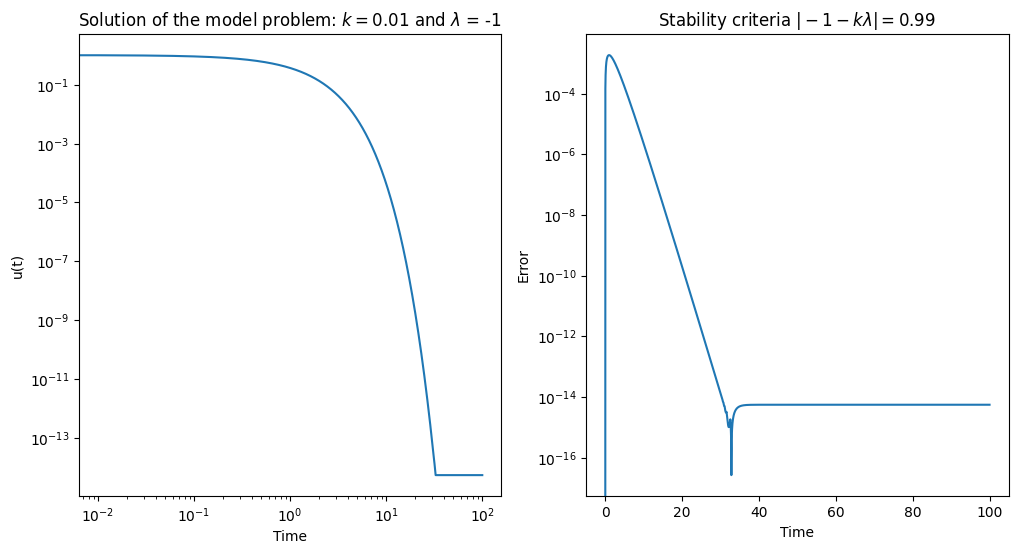

<Figure size 640x480 with 0 Axes>

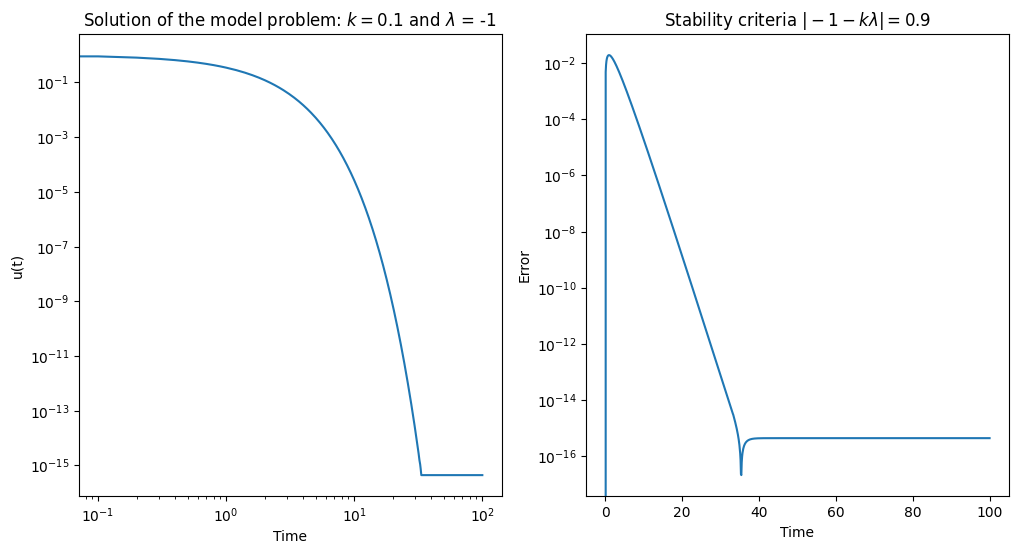

<Figure size 640x480 with 0 Axes>

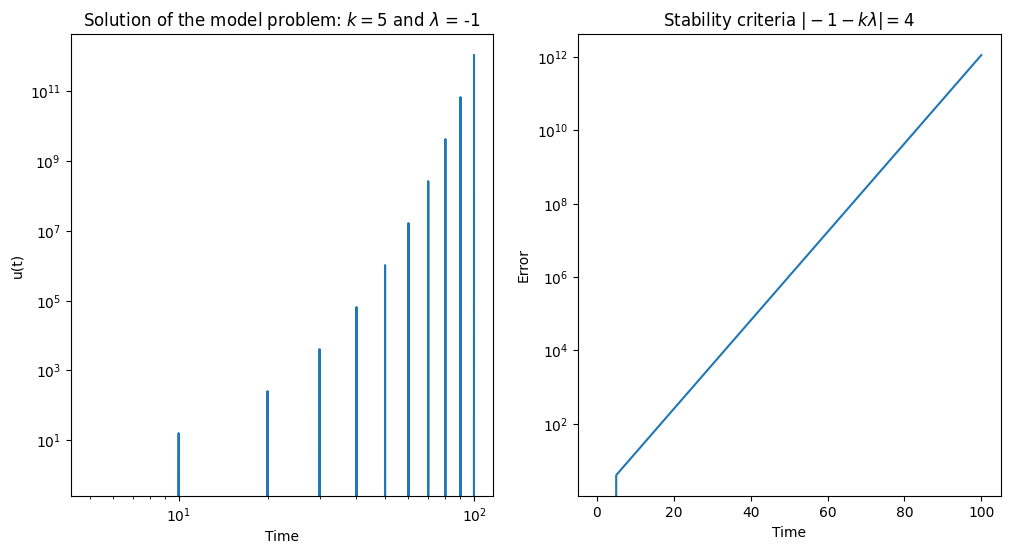

In [67]:
#p is lambda in the course material
k_vec = [0.01, 0.1, 5]

for j in range(len(k_vec)):
  T = 100
  u0 = 1;
  u_vec, par = scalar_time(T, fun1, u0, k_vec[j])

  #Stability for explicit euler
  stab_crit = abs(-1 - k_vec[j]*par.p)

  t_vec = np.arange(par.t0, par.T + par.k, par.k)

  exact_sol_vec = np.zeros(len(t_vec))
  for i in range(len(t_vec)):
    exact_sol_vec[i] = float(u0 * np.exp(par.p*t_vec[i]))

  error = np.abs(exact_sol_vec - u_vec)

  plt.figure(i)
  plt.figure(figsize=(12,6))
  plt.subplot(121)
  plt.loglog(t_vec, u_vec)
  plt.xlabel("Time")
  plt.ylabel("u(t)")
  plt.title("Solution of the model problem: $k = $" + str(k_vec[j]) + " and $\lambda$ = " + str(par.p))
  plt.subplot(122)
  plt.semilogy(t_vec, error)
  plt.xlabel("Time")
  plt.ylabel("Error")
  plt.title("Stability criteria $|-1 - k\lambda| = $" + str(stab_crit))
  plt.show()

**Assignment 2**

<Figure size 640x480 with 0 Axes>

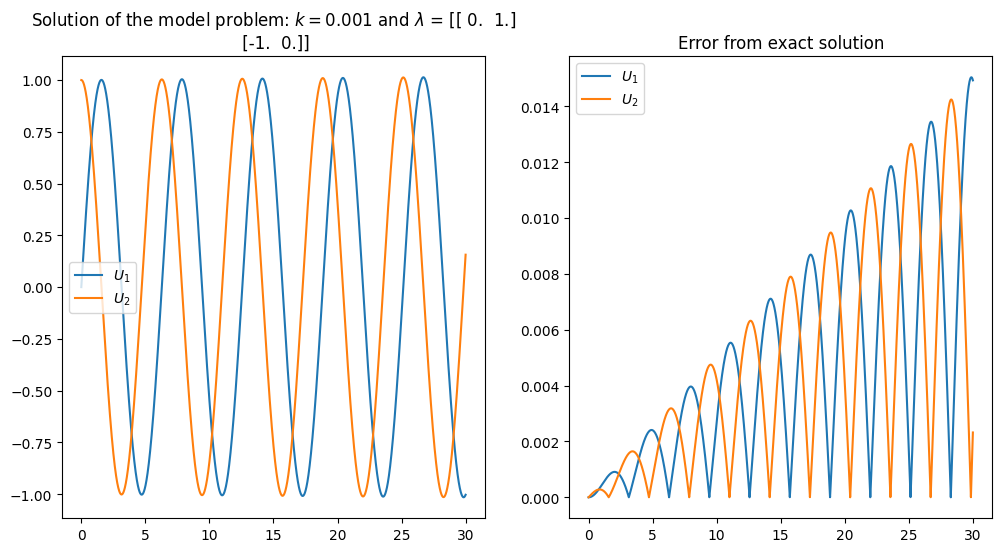

<Figure size 640x480 with 0 Axes>

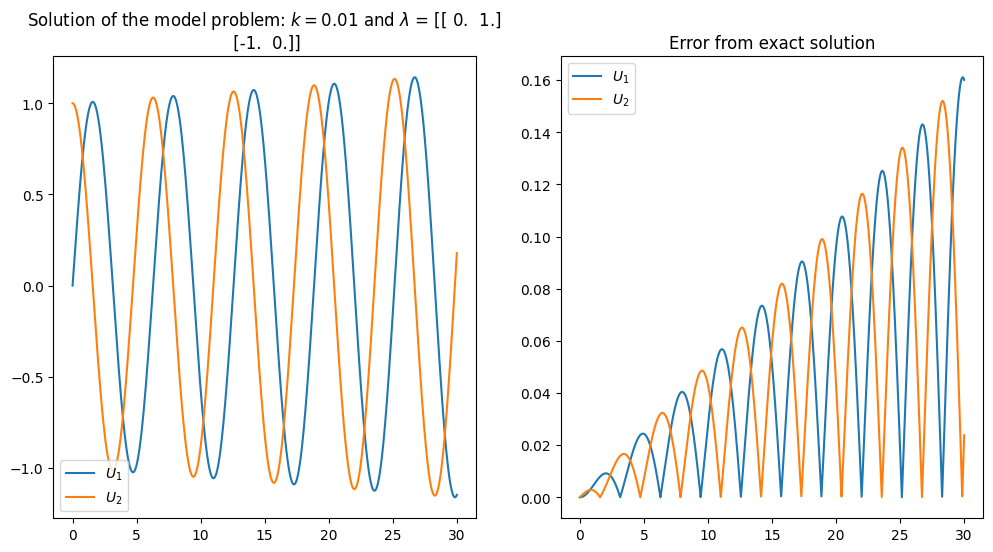

<Figure size 640x480 with 0 Axes>

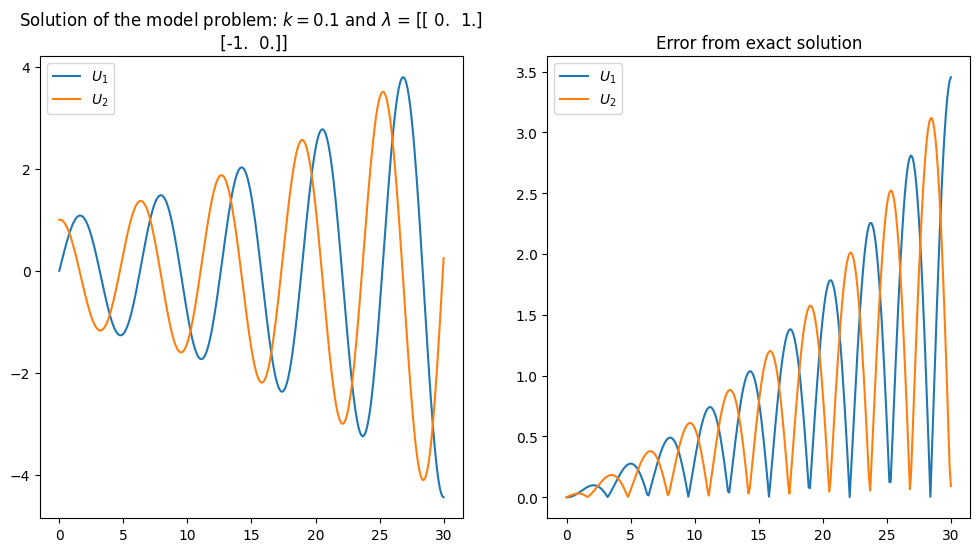

<Figure size 640x480 with 0 Axes>

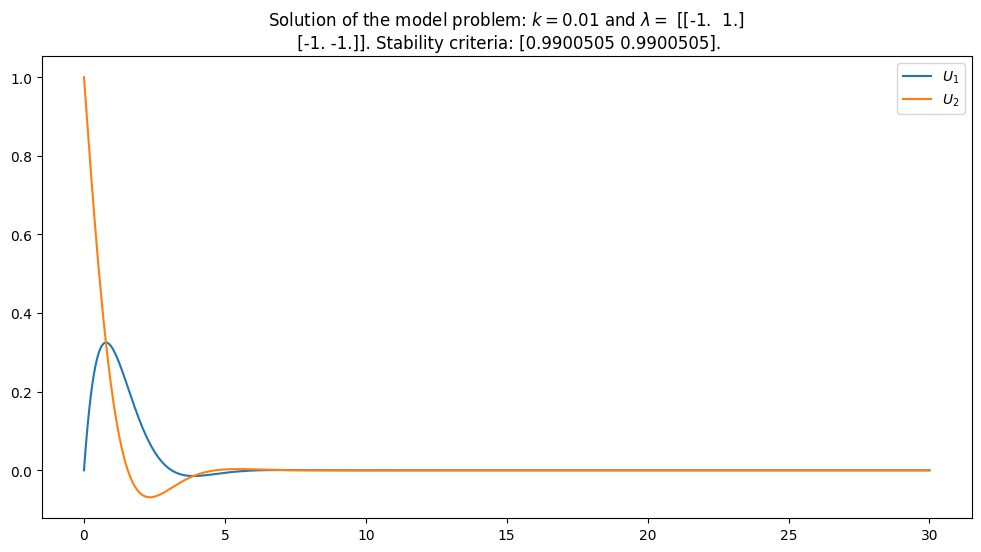

<Figure size 640x480 with 0 Axes>

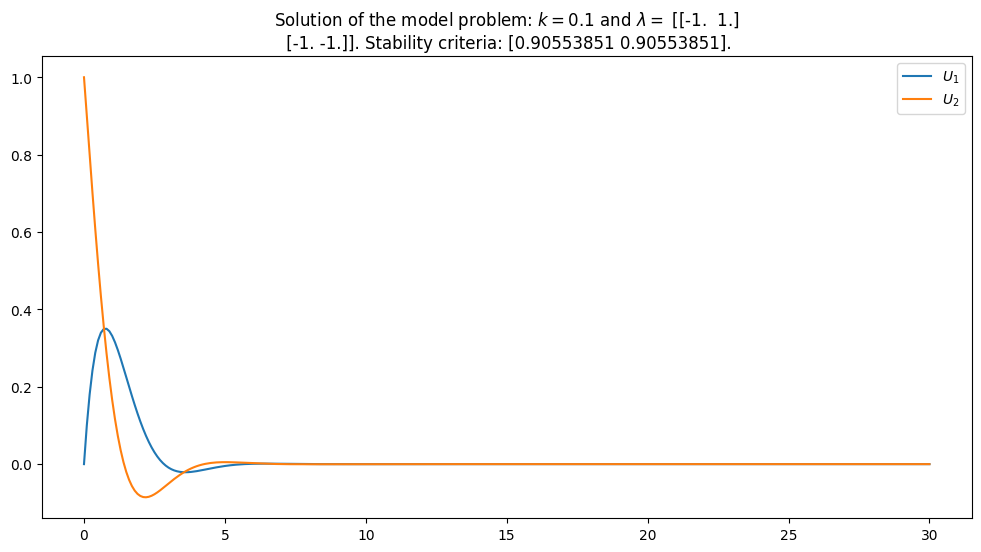

<Figure size 640x480 with 0 Axes>

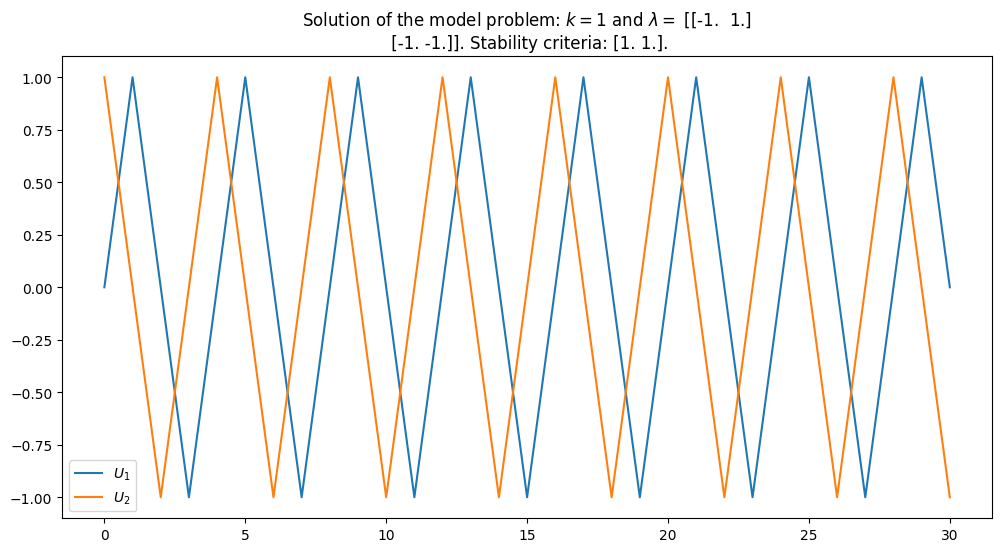

In [69]:
#Accuracy for different timesteps

k_vec = [0.001, 0.01, 0.1]

for j in range(len(k_vec)):
  p = np.array([[0, 1],[-1, 0]], dtype="float")
  T = 30
  u0 = np.array([0, 1], dtype = "float");
  u_vec, par = system_time(T, fun2, u0, k_vec[j], p)
  t_vec = np.arange(par.t0, par.T + par.k, par.k)
  exact_sol_vec = np.zeros((len(t_vec), 2))

  for i in range(len(t_vec)):
      exact_sol_vec[i] = exact_fun(t_vec[i])

  error = np.abs(exact_sol_vec-u_vec)
  eigenval, eigenvec = np.linalg.eig(par.p)
  conv_criteria2 = abs(-np.array([1, 1]) - (k_vec[j] * eigenval))

  #Plotting
  plt.figure(j)
  plt.figure(figsize=(12,6))
  plt.subplot(121)
  plt.title("Solution of the model problem: $k = $" + str(k_vec[j]) + " and $\lambda$ = " + str(par.p))
  plt.plot(t_vec, u_vec)
  plt.legend(["$U_1$", "$U_2$"])
  plt.subplot(122)
  plt.title("Error from exact solution")
  plt.plot(t_vec, error)
  plt.legend(["$U_1$", "$U_2$"])
  plt.show()


#Stability for different timesteps

k_vec = [0.01, 0.1, 1]

for j in range(len(k_vec)):
  p = np.array([[-1, 1],[-1, -1]], dtype="float")
  T = 30
  u0 = np.array([0, 1], dtype = "float");
  u_vec, par = system_time(T, fun2, u0, k_vec[j], p)
  t_vec = np.arange(par.t0, par.T + par.k, par.k)

  eigenval, eigenvec = np.linalg.eig(par.p)
  conv_criteria2 = abs(-np.array([1, 1]) - (k_vec[j] * eigenval))

  #Plotting
  plt.figure(j)
  plt.figure(figsize=(12,6))
  plt.title("Solution of the model problem: $k = $" + str(k_vec[j]) + " and $\lambda =$ " + str(par.p) + ". Stability criteria: " + str(conv_criteria2) + ".")
  plt.plot(t_vec, u_vec)
  plt.legend(["$U_1$", "$U_2$"])
  plt.show()

# **Discussion**

The stability of the scalar function follows the theory in chapter 13.4 which says that the method should be stable for $|-1 - k\lambda| < 1$. The last figure of the scalar problem shows that the method is not stable for that combination.

The accuracy of the scalar problem is scaling as expected. According to chapter 13.5 the global error should decrease with the same factor that the timestep decreases with. This can be seen for the figures with $k=0.1$ and $k=0.01$.

The same results can be seen in the system assignment where we instead treat each eigeinvalue of the matrix $\lambda$. The accuracy and the stability reacts the same way as in the scalar version of the problem as can be seen in the results for the system time iteration.